# Final Notebook

## This is the final Notebook

## It just loads the tokenizer, weights and predicts weights

## You can use Categorical Distribution, Argmax, and Beam Search evaluating functions

## You can plot attention to see if the generated outputs are interpreting the model well or now

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
from IPython.display import Image
from IPython.core.display import HTML
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
# import tensorflow as tf
import xml.etree.ElementTree
import numpy as np
import pandas as pd
import re
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
np.random.seed(42)
tf.random.set_seed(32)

In [4]:
print(tf.__version__)

2.2.0


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
image_folder = '/content/drive/My Drive/Colab Notebooks/Medical data case study'
annotation_folder = '/content/drive/My Drive/Colab Notebooks/Medical data case study/ecgen-radiology'

In [0]:
df=pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/x_ray_image_with_report (2).csv")
# df.head()


In [0]:
all_findings, all_impressions, all_img_names, report_id=df['findings'], df['impressions'],df['image_names'], df['report_id']


In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (512, 624))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [27]:
IMG_SHAPE=(512, 624, 3)
image_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
top_k = 1225
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",split=' ', char_level=False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
import pickle
with open('/content/drive/My Drive/Colab Notebooks/checkpoints_1/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [12]:
train_seqs = tokenizer.texts_to_sequences(all_impressions)
print(len(tokenizer.word_index))
print(tokenizer.word_index['<end>'])

1225
3


### Splitting File, so that Analysis is done mostly on Test Images

In [13]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = 114
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_names,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=40)
# Create training and validation sets using an 80-20 split
img_name_test, img_name_val, cap_test, cap_val = train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=40)
print(len(img_name_train), len(cap_train), len(img_name_val), len(cap_val))
print(len(img_name_test), len(cap_test))   

2672 2672 335 335
334 334


In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [0]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 64   #earlier 256
units = 128 #earlier 256
vocab_size = 1225
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (252, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 252              

# Model

In [0]:
## https://www.tensorflow.org/tutorials/text/image_captioning
## Code taken from official Tensorflow website
np.random.seed(42)
tf.random.set_seed(32)
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc_1 = tf.keras.layers.Dense(3*embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
      

    def call(self, x):
        x = self.fc_1(x)
        x = tf.nn.relu(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        # print("output from CNN encoder : ", x)
        return x 

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, kernel_initializer='glorot_uniform')
    self.fc2 = tf.keras.layers.Dense(vocab_size, kernel_initializer='glorot_uniform')

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)   

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    # https://www.tensorflow.org/api_docs/python/tf/reshape
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    
    return x, state, attention_weights

  def reset_state(self, batch_size):            
    return tf.zeros((batch_size, self.units))



In [0]:
encoder = CNN_Encoder(embedding_dim) 
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/checkpoints_2/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
ckpt.restore(ckpt_manager.latest_checkpoint)
ckpt_manager.checkpoints

['/content/drive/My Drive/Colab Notebooks/checkpoints_2/train/ckpt-11',
 '/content/drive/My Drive/Colab Notebooks/checkpoints_2/train/ckpt-12',
 '/content/drive/My Drive/Colab Notebooks/checkpoints_2/train/ckpt-13',
 '/content/drive/My Drive/Colab Notebooks/checkpoints_2/train/ckpt-14',
 '/content/drive/My Drive/Colab Notebooks/checkpoints_2/train/ckpt-15']

## Evaluating Techniques
1. evaluate_argmax- No Beam Search, takes argmax
2. evaluate- No Beam Search, but with categorical distribution
3. evaluate_beam- Beam Search with Categorical distribution
4. evaluate_image- evaluate_beam without attention weights
### Note: Evaluate beam with argmax function does not give <end> token

In [0]:
def evaluate_argmax(image):
  attention_plot = np.zeros((max_length, 252))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
  result = []
  for i in range(max_length): 
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted
    if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
        return result, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep
  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot
def evaluate(image):
  attention_plot = np.zeros((max_length, 252))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot   
    dec_input = tf.expand_dims([predicted_id], 0)
  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

def evaluate_beam(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    while len(result[0][0]) < max_length:
        i=0                                
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          # word_preds = np.argsort(predictions[0])[-beam_index:]   
          word_preds = tf.random.categorical(predictions, 1)[0][-beam_index:].numpy()              
          # word_preds=tf.argmax(predictions[0])[-beam_index:].numpy()
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]   
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]        
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i == '<end>':
          final_caption.append(" <end>")
          break
        if i != '<end>':
          final_caption.append(i)
          
    attention_plot = attention_plot[:len(result), :]
    return final_caption[1:],attention_plot       
def evaluate_image(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0                                
        temp = []
        for s in result:

          predictions, hidden, _ = decoder(dec_input, features, hidden)

          # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          # word_preds = np.argsort(predictions[0])[-beam_index:]   
          word_preds = tf.random.categorical(predictions, 1)[0][-beam_index:].numpy()              
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]   
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]        
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i == '<end>':
          final_caption.append(" <end>")
          break
        if i != '<end>':
          final_caption.append(i)
            
        # else:
        #     break
    
    final_caption = ' '.join(final_caption[1:])
    # final_caption=final_caption + ' <end>'
    # print("shape beam", attention_plot.shape)
    return final_caption[1:]      
import PIL.Image     
def plot_attention(image, result, attention_plot):
    # img_name_to_save=image
    temp_image = np.array(PIL.Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)    
    for l in range(len_result):
        # print("shape attention plot[l]= ", attention_plot.shape)
        temp_att = np.resize(attention_plot[l], (8, 8))          
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        # print("temp attn shape",temp_att.shape)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.savefig("newest.png") # save as png
    plt.show()                                                                  

# Output Analysis

Prediction Caption: true acute abnormality <end>


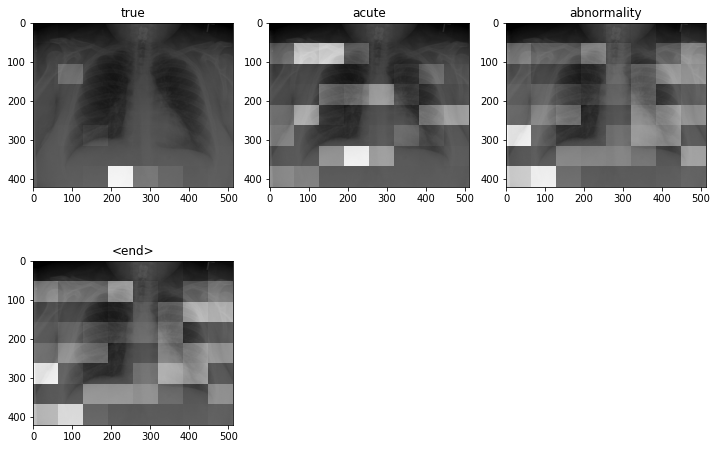

In [28]:
# captions on the test set
max_length=114
image=img_name_test[827]

result, attention_plot = evaluate(image)

print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [37]:
result, _ = evaluate(image)
print(result)

['no', 'acute', 'disease', '<end>']
